# 1. Getting Started
## An introduction to ice flow modeling with the Parallel Ice Sheet Model (PISM)

*Author: Andy Aschwanden*

In [1]:
from functools import partial

from pathlib import Path
import matplotlib.pylab as plt
from matplotlib import colors
import numpy as np
import xarray as xr
import cf_xarray.units  # otherwise we get a Parser error
import pint_xarray

from pism_tutorials.download import download_files
from pism_tutorials.plotting import register_colormaps
from pism_tutorials.processing import preprocess_nc

register_colormaps()
xr.set_options(keep_attrs=True)

In [2]:
# The name of the PISM Cloud S3 bucket
bucket_name = "pism-cloud-data"

In [3]:
tutorial_files = {"initial_state": {"path": "initial_states", "files": ["g1200m_id_BAYES-MEDIAN_1980-1-1_1984-12-31.nc"]}, 
                  "basal_heatflux": {"path": "bheatflux", "files": ["geothermal_heat_flow_map_10km.nc"]},
                  "climate": {"path": "ismip6", "files": ["MARv3.9_MIROC5-rcp26_climate_1960-2100_v1.nc", "MARv3.9_MIROC5-rcp85_climate_1960-2100_v1.nc"]},
                  "ocean": {"path": "ismip6", "files": ["MAR3.9_MIROC-ESM-CHEM_rcp26_ocean_1960-2100_v4.nc", "MAR3.9_MIROC-ESM-CHEM_rcp85_ocean_1960-2100_v4.nc"]},
                  "grid": {"path": "grids", "files": ["pism-bedmachine.nc"]}}

to_download = []
for forcing_type, forcing in tutorial_files.items():
    for f in forcing["files"]:
        d = Path(forcing["path"])
        d.mkdir(parents=True, exist_ok=True)
        p = d / Path(f)
        to_download.append(str(p))


In [4]:
# Download files if not exist.
# Set "overwrite=True" to overwrite existing files.
download_files(bucket_name, to_download, overwrite=False)

In [5]:
init_file = Path(tutorial_files["initial_state"]["path"]) / Path(tutorial_files["initial_state"]["files"][0])
init_ds = xr.open_dataset(init_file, decode_timedelta=True)

climate_files = Path(tutorial_files["climate"]["path"]).glob("*_climate_*.nc")
climate_ds = xr.open_mfdataset(climate_files,                       
                               preprocess=partial(preprocess_nc, regexp="_(.+?)_", dim="gcm"),
                               chunks="auto",
                               parallel=True,             
                               decode_cf=True,
                               decode_timedelta=True,
                               combine="nested",
                               concat_dim="gcm")

climate_ds["climatic_mass_balance_anomaly"] = climate_ds["climatic_mass_balance_anomaly"].pint.quantify().pint.to("kg m-2 yr-1")

bhf_file = Path(tutorial_files["basal_heatflux"]["path"]) / Path(tutorial_files["basal_heatflux"]["files"][0])
bhf_ds = xr.open_dataset(bhf_file, decode_timedelta=True)

## Initial state

Generating initial states that are compatible with observations and our understanding of ice flow is still an active area of research. For the purposes of this tutorial we use an initial state adapted from {cite}`Aschwanden2022`.

```{bibliography}
@article{Aschwanden2022,
author = {Aschwanden, A. and Brinkerhoff, D. J.},
doi = {10.1029/2022GL099058},
file = {:Users/andy/Documents/Mendeley Desktop/Aschwanden, Brinkerhoff - 2022 - Calibrated Mass Loss Predictions for the Greenland Ice Sheet.pdf:pdf;:Users/andy/Documents/Mendeley Desktop/Aschwanden, Brinkerhoff - 2022 - Calibrated Mass Loss Predictions for the Greenland Ice Sheet(2).pdf:pdf},
issn = {0094-8276},
journal = {Geophysical Research Letters},
keywords = {Bayesian calibration,Greenland,data assimilation,ice sheet modeling,sea level rise,uncertainty quantification},
month = {oct},
number = {19},
title = {{Calibrated Mass Loss Predictions for the Greenland Ice Sheet}},
url = {https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022GL099058},
volume = {49},
year = {2022}
}
```

In summary, the inital state was obtained by combining an energy field from simulation spanning a glacial cycle, present day ice sheet geometry, and basal fields calibrated using present day surface speeds.

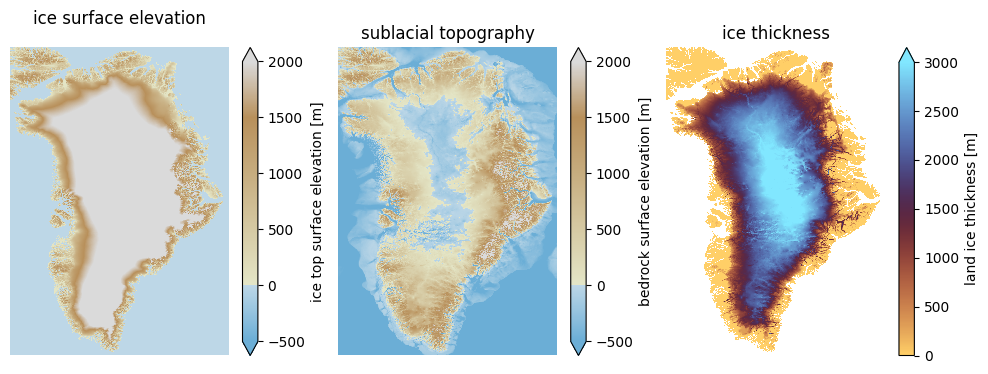

In [6]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
init_ds["usurf"].plot(ax=axs[0], cmap="bath_topo", vmin=-500, vmax=2000, extend="both")
init_ds["topg"].plot(ax=axs[1], cmap="bath_topo", vmin=-500, vmax=2000, extend="both")
init_ds["thk"].where(init_ds["thk"] > 0).plot(ax=axs[2], cmap="managua", vmax=3000, extend="max")
axs[0].set_title("ice surface elevation")
axs[1].set_title("sublacial topography")
axs[2].set_title("ice thickness")
for ax in axs:
    ax.set_axis_off()

Download `ITS_LIVE` Greenland Mosaic (if needed).

In [7]:
itslive_file = "GRE_G0240_0000.nc"

if not Path(itslive_file).is_file():
    its_ds = xr.open_dataset(f"s3://its-live-data/velocity_mosaic/v1/static/{itslive_file}",
                             decode_timedelta=True,
                             chunks="auto",
                             engine="h5netcdf",)[["v"]]
    its_ds.to_netcdf(itslive_file)
    del its_ds

itslive_ds = xr.open_dataset(itslive_file,
                             decode_timedelta=True,
                             engine="h5netcdf",
)

OSError: Unable to synchronously open file (file signature not found)

In [ ]:
speed_sim = init_ds["velsurf_mag"]
speed_obs = itslive_ds["v"].interp_like(init_ds["velsurf_mag"])

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
speed_sim.plot(ax=axs[0], cmap="speed_colorblind", vmin=10, vmax=1500, extend="both")
speed_obs.plot(ax=axs[1], cmap="speed_colorblind", vmin=10, vmax=1500, extend="both")
(speed_sim-speed_obs).plot(ax=axs[2], cmap="RdBu_r", vmin=-250, vmax=250, extend="both")
axs[0].set_title("Simulated")
axs[1].set_title("Observed")
axs[2].set_title("Simulated - Observed")
for ax in axs:
    ax.set_axis_off()
    

## Climate forcing

In [ ]:
itslive_ds

In [ ]:
anomaly_2090s = climate_ds.sel({"time": slice("2090", "2099")}).mean(dim="time")

fig = anomaly_2090s["climatic_mass_balance_anomaly"].plot(col="gcm", vmin=-2500, vmax=2500, cmap="RdBu", extend="both", figsize=(8, 4)).fig
for ax in fig.axes[:2]:
    ax.set_axis_off()
fig.suptitle("Climatic Mass Balance Anomaly Mean 2090-2099")
fig.subplots_adjust(top=0.85)
fig = anomaly_2090s["ice_surface_temp_anomaly"].plot(col="gcm", cmap="Reds", vmin=0, vmax=20, extend="max", figsize=(8, 4)).fig
for ax in fig.axes[:2]:
    ax.set_axis_off()
fig.suptitle("Ice Surface Temperature Anomaly Mean 2090-2099")
fig.subplots_adjust(top=0.85)


In [ ]:
f = "mpirun -np 4 pism -eisII A -grid.Mx 101 -grid.My 101"

f = "mpirun -np 8 pism -bootstrap  -time.calendar standard -time.start 2008-01-01 -time.end 2018-01-01 -surface.models ismip6 -surface.ismip6.reference_file g1200m_id_BAYES-MEDIAN_1980-1-1_1984-12-31.nc -surface.ismip6.file MARv3.9_ACCESS1.3-rcp85_climate_1960-2100_v1.nc  -i g1200m_id_BAYES-MEDIAN_1980-1-1_1984-12-31.nc  -input.regrid.file g1200m_id_BAYES-MEDIAN_1980-1-1_1984-12-31.nc -input.regrid.vars litho_temp,enthalpy,age,tillwat,bmelt,ice_area_specific_volume,thk -grid.file pism-bedmachine.nc -grid.dx 3600m -grid.dy 3600m -grid.Mz 101 -grid.Lz 4000 -grid.Mbz 11 -grid.Lbz 1000"

In [ ]:
!$f 

In [ ]:
climate_ds.drop_vars(["time_bnds"]).pint.quantify()

In [ ]:
resolution = "3600m"

grid_params = {
    "grid.dx": resolution,
    "grid.dy": resolution,
    "grid.Mz": 101,
    "grid.Lz": 4000,
    "grid.Mbz": 11,
    "grid.Lbz": 1000,
    "input.regrid.vars": "litho_temp,enthalpy,age,tillwat,bmelt,ice_area_specific_volume,thk"
}

time_params = {
    "time.start": "2015-01-01",
    "time.end": "2099-31-12",
}

climate_params = {
    "surface.models": "ismip6",
    "surface.ismip6.reference_file": "g1200m_id_BAYES-MEDIAN_1980-1-1_1984-12-31.nc",
    "surface.ismip6.file": "MARv3.9_ACCESS1.3-rcp85_climate_1960-2100_v1.nc"
}

In [ ]:
def dicts2str(*args: dict) -> str:
    """
    Convert one or more dictionaries into a single string of key-value pairs.

    Each key-value pair is formatted as `-key value`, and dictionaries are
    concatenated with a space between them.

    Parameters
    ----------
    *args : dict
        One or more dictionaries to be converted.

    Returns
    -------
    str
        A single string representation of the dictionaries.
    """
    def d2s(d: dict) -> str:
        return " ".join(f"-{k} {v}" for k, v in d.items())

    return " ".join(d2s(d) for d in args if d)


In [ ]:
dicts2str(grid_params, time_params)